In [13]:
import numpy as np
import matplotlib.pyplot as plt

import os
import sys

import tensorflow as tf
import tensorflow.keras as keras
import keras.metrics as metrics
from keras.callbacks import EarlyStopping

import data_visualisation as dv
import data_augmentation as da

import models.cnn as cnn

from sklearn.model_selection import KFold

# Load Data

In [2]:
thismodule = sys.modules[__name__]
NP_DATA = 'data/DAT_China.npz'

with np.load(NP_DATA, allow_pickle=True) as data:
    for k in data.keys():
        if 'text' in k:
            setattr(thismodule, k, data[k])
        else:
            setattr(thismodule, k, data[k].astype(float))
            
print(X_train.shape)
print(Y_train.shape)

print(X_test.shape)
print(Y_test.shape)

(564, 1000, 12)
(564,)
(140, 1000, 12)
(140,)


In [3]:
# convert RBBB labels to Normal 
Y_train = np.where(Y_train == 1, True, False)
Y_test = np.where(Y_test == 1, True, False)

In [5]:
# distribution of classes
print(np.sum(Y_train) / len(Y_train))
print(np.sum(Y_test)/ len(Y_test))

0.25354609929078015
0.2357142857142857


# Augment Code

In [11]:
def augment_ecg_signal(signal,):
    drifted_signal, _ = da.add_random_baseline_drift(signal, strength_range=(2 ,3), drift_wavelength_range=(500,1500))
    noised_drifted_signal = da.add_random_noise(drifted_signal, (0.1, 0.2))
    return signal

def augment_ecg_signal_batch(signals, labels, batch_size):
    while True:
        
        indices = np.random.randint(0, signals.shape[0], size=batch_size)
        batch = signals[indices]
        batch_labels = labels[indices]
        
        augmented_batch = np.array([augment_ecg_signal(sample) for sample in batch])
        
        yield (augmented_batch, batch_labels)

# Visualise a sample of the data

(1000, 12)
False


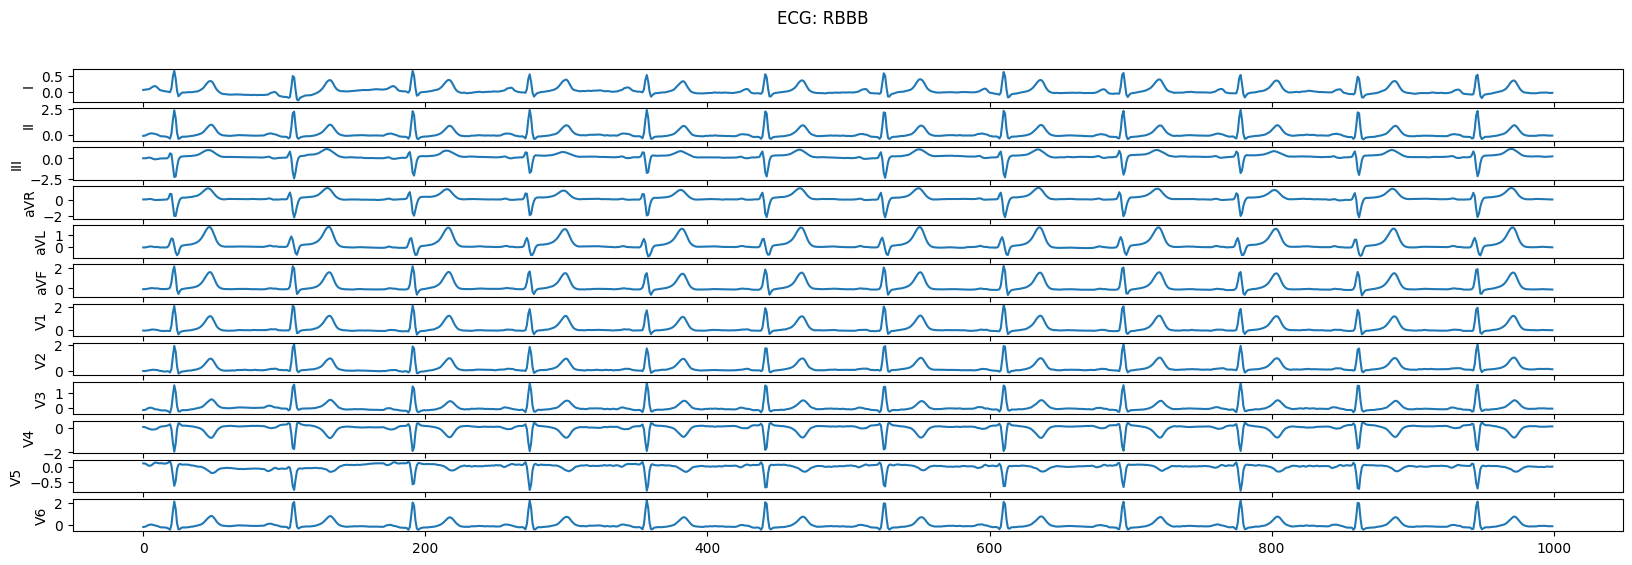

In [6]:
rand_index = np.random.randint(0, X_train.shape[0])
rand_sample = X_train[rand_index]
label = Y_train[rand_index]
label_text = Y_train_text[rand_index]
# rand_sample = Normal_data[0]
print(rand_sample.shape)
print(label)

dv.plot_12_lead_ecg(rand_sample, label_text)

# Create Model

In [7]:
X_input = keras.Input(shape=X_train.shape[1:])
num_classes = 1
output, feature_extractor = cnn.model(X_input, num_classes=num_classes, filters=[32, 64, 128], kernels=[5,3,3], hidden_units=[128], dropout=[0.5])


2024-05-22 18:44:06.494946: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-05-22 18:44:06.560041: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-05-22 18:44:06.560277: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-05-22 18:44:06.560746: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorF

# Pre-trained model

In [11]:
feature_extractor_model = keras.Model(inputs=X_input, outputs=feature_extractor)
feature_extractor_model.load_weights('models/cnn_model.keras', by_name=True)
# for layer in feature_extractor_model.layers:
#     layer.trainable = False
    
X = keras.layers.Dense(128, activation='relu')(feature_extractor)
X_out = keras.layers.Dense(num_classes, activation='sigmoid')(X)

new_model = keras.Model(inputs=X_input, outputs=X_out)
new_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy', metrics.Precision(), metrics.Recall(), metrics.AUC()])

In [14]:
history = new_model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=100, batch_size=32, verbose=1)

Epoch 1/100
11/11 [==============================] - 0s 8ms/step - loss: 0.0492 - accuracy: 0.9819 - precision: 1.0000 - recall: 0.9516 - auc: 0.9998 - val_loss: 0.9626 - val_accuracy: 0.8298 - val_precision: 1.0000 - val_recall: 0.3846 - val_auc: 0.8462
Epoch 2/100
11/11 [==============================] - 0s 6ms/step - loss: 0.0255 - accuracy: 0.9880 - precision: 1.0000 - recall: 0.9677 - auc: 0.9998 - val_loss: 0.3481 - val_accuracy: 0.9574 - val_precision: 1.0000 - val_recall: 0.8462 - val_auc: 0.9581
Epoch 3/100
11/11 [==============================] - 0s 8ms/step - loss: 0.0141 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - val_loss: 0.3177 - val_accuracy: 0.9574 - val_precision: 1.0000 - val_recall: 0.8462 - val_auc: 0.9548
Epoch 4/100
11/11 [==============================] - 0s 6ms/step - loss: 0.0172 - accuracy: 0.9970 - precision: 0.9920 - recall: 1.0000 - auc: 1.0000 - val_loss: 0.3435 - val_accuracy: 0.9574 - val_precision: 1.0000 - val_recall: 0.846

In [22]:
from sklearn.metrics import classification_report, f1_score, accuracy_score, precision_score, recall_score

# evaluate the model
y_pred = new_model.predict(X_test)
y_pred_binary = np.round(y_pred)
y_true = y_test

print(classification_report(y_true, y_pred_binary))

# AUC score
from sklearn.metrics import roc_auc_score

print("Accuracy score:", accuracy_score(y_true, y_pred_binary))
print("AUC score:", roc_auc_score(y_true, y_pred))
print("F1 score:", f1_score(y_true, y_pred_binary))
print("Precision score:", precision_score(y_true, y_pred_binary))
print("Recall score:", recall_score(y_true, y_pred_binary))

3/3 [==============================] - 0s 1ms/step
              precision    recall  f1-score   support

         0.0       0.95      0.98      0.97        57
         1.0       0.97      0.92      0.95        39

    accuracy                           0.96        96
   macro avg       0.96      0.95      0.96        96
weighted avg       0.96      0.96      0.96        96

Accuracy score: 0.9583333333333334
AUC score: 0.9797570850202428
F1 score: 0.9473684210526315
Precision score: 0.972972972972973
Recall score: 0.9230769230769231


# Non Pretrained Model

In [16]:
model2, _ = cnn_model(X_input, num_classes=num_classes)

model2 = keras.Model(inputs=X_input, outputs=model2)
model2.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy', metrics.Precision(), metrics.Recall(), metrics.AUC()])
history2 = model2.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=100, batch_size=32, verbose=1)

Epoch 1/100
11/11 [==============================] - 2s 27ms/step - loss: 0.6432 - accuracy: 0.6476 - precision_1: 0.5636 - recall_1: 0.2500 - auc_1: 0.6253 - val_loss: 0.6632 - val_accuracy: 0.7872 - val_precision_1: 0.6000 - val_recall_1: 0.6923 - val_auc_1: 0.7930
Epoch 2/100
11/11 [==============================] - 0s 9ms/step - loss: 0.5723 - accuracy: 0.6988 - precision_1: 0.7609 - recall_1: 0.2823 - auc_1: 0.7607 - val_loss: 0.7079 - val_accuracy: 0.4255 - val_precision_1: 0.3250 - val_recall_1: 1.0000 - val_auc_1: 0.7726
Epoch 3/100
11/11 [==============================] - 0s 9ms/step - loss: 0.5367 - accuracy: 0.7651 - precision_1: 0.7674 - recall_1: 0.5323 - auc_1: 0.8171 - val_loss: 0.6726 - val_accuracy: 0.7021 - val_precision_1: 0.4815 - val_recall_1: 1.0000 - val_auc_1: 0.8122
Epoch 4/100
11/11 [==============================] - 0s 9ms/step - loss: 0.4427 - accuracy: 0.8343 - precision_1: 0.8791 - recall_1: 0.6452 - auc_1: 0.8888 - val_loss: 0.6187 - val_accuracy: 0.7872 

Training on fold 1


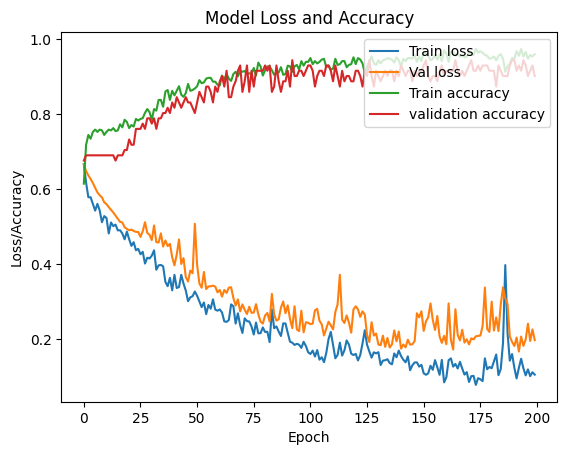

Evaluating the model for fold 1
F1 score for fold 1 0.8493150684931509
Accuracy score for fold 1 0.9214285714285714
Training on fold 2


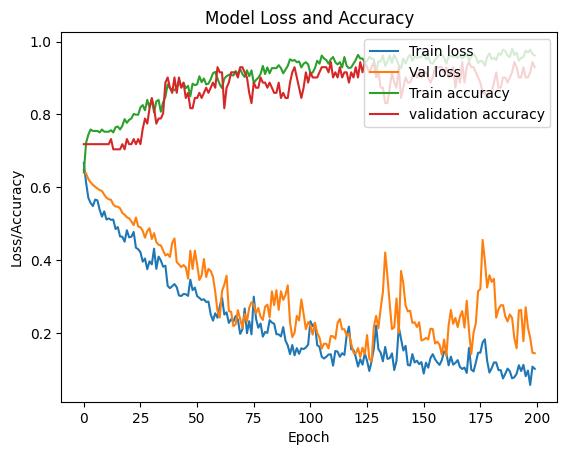

Evaluating the model for fold 2
F1 score for fold 2 0.8732394366197183
Accuracy score for fold 2 0.9357142857142857
Training on fold 3


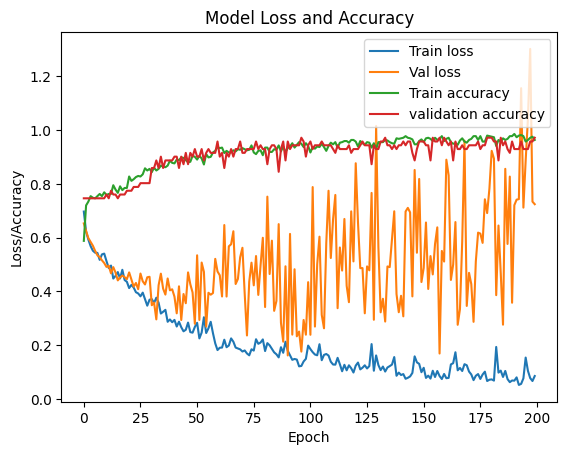

Evaluating the model for fold 3
F1 score for fold 3 0.927536231884058
Accuracy score for fold 3 0.9642857142857143
Training on fold 4


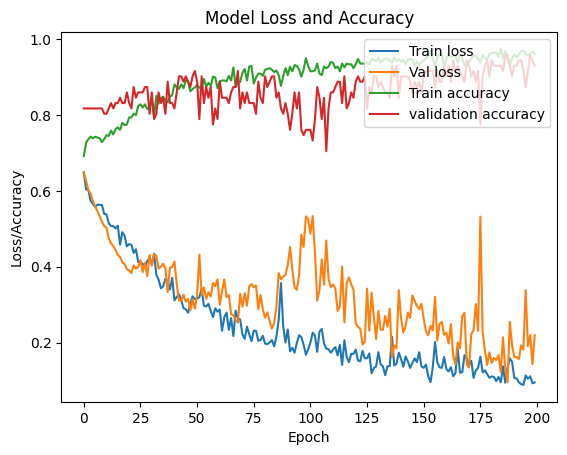

Evaluating the model for fold 4
F1 score for fold 4 0.8378378378378378
Accuracy score for fold 4 0.9142857142857143
Training on fold 5


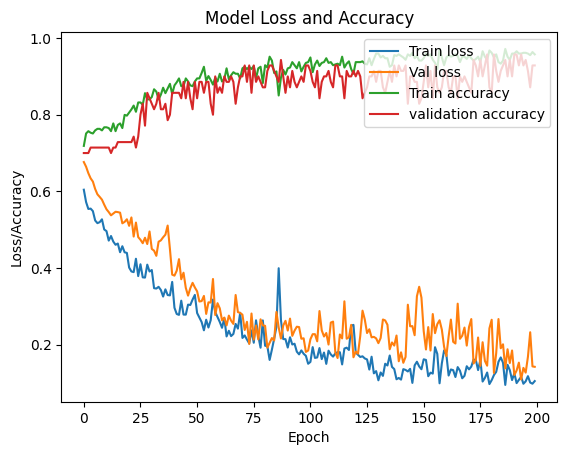

Evaluating the model for fold 5
F1 score for fold 5 0.8888888888888888
Accuracy score for fold 5 0.9428571428571428
Training on fold 6


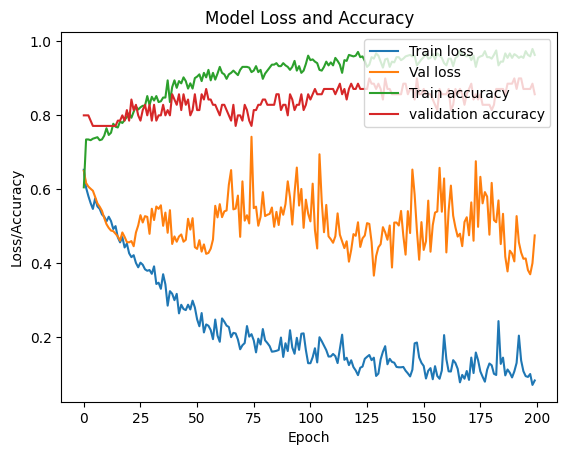

Evaluating the model for fold 6
F1 score for fold 6 0.8533333333333334
Accuracy score for fold 6 0.9214285714285714
Training on fold 7


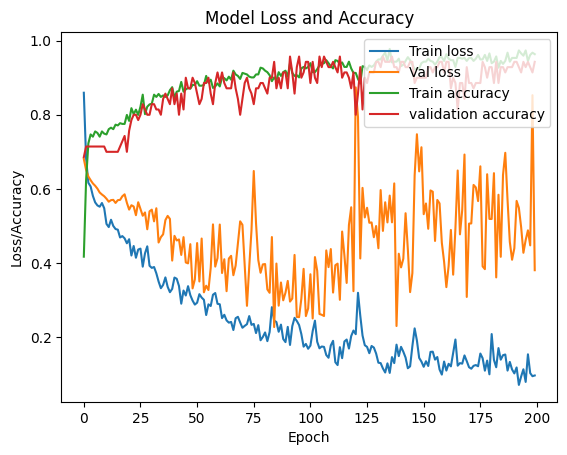

Evaluating the model for fold 7
F1 score for fold 7 0.8571428571428571
Accuracy score for fold 7 0.9285714285714286
Training on fold 8


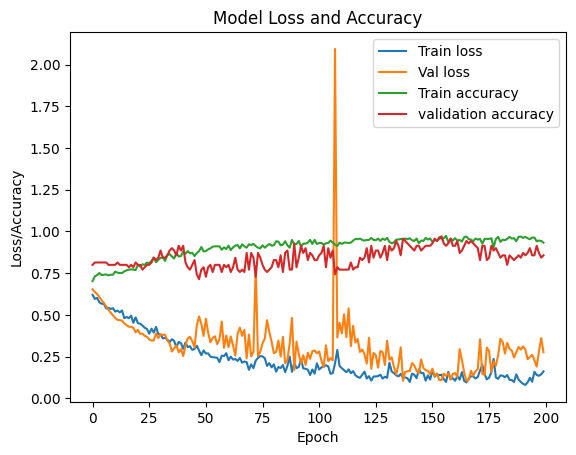

Evaluating the model for fold 8
F1 score for fold 8 0.7999999999999999
Accuracy score for fold 8 0.8857142857142857


In [19]:
from sklearn.metrics import classification_report, f1_score, accuracy_score, precision_score, recall_score

X_input = keras.Input(shape=X_train.shape[1:])
num_classes = 1

k = 8
kf = KFold(n_splits=k, shuffle=True, random_state=42)

for i, (train_index, val_index) in enumerate(kf.split(X_train)):
    print(f"Training on fold {i+1}")
    X_train_fold, X_val_fold = X_train[train_index], X_train[val_index]
    Y_train_fold, Y_val_fold = Y_train[train_index], Y_train[val_index]
    
    # reset the weights of the model 
    output, feature_extractor = cnn.model(X_input, num_classes=num_classes, filters=[32, 64], kernels=[5,3], hidden_units=[32, 16], dropout=[0.5, 0.5])
    model = keras.Model(inputs=X_input, outputs=output)
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy', metrics.Precision(), metrics.Recall(), metrics.AUC()])
    
    # early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
    data_gen = augment_ecg_signal_batch(X_train_fold, Y_train_fold, 32)
    
    # history = model.fit(data_gen, validation_data=(X_val_fold, Y_val_fold), epochs=100, batch_size=32, steps_per_epoch=len(X_train) // 32, callbacks=[early_stopping], verbose=0)
    
    history = model.fit(X_train_fold, Y_train_fold, validation_data=(X_val_fold, Y_val_fold), epochs=200, batch_size=32, verbose=0)
    
    # plot the loss and accuracy
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model Loss and Accuracy')
    plt.ylabel('Loss/Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train loss', 'Val loss', 'Train accuracy', 'validation accuracy'], loc='upper right')
    plt.show()
    
    print(f"Evaluating the model for fold {i+1}")
    Y_pred_fold = model.predict(X_test, verbose=0)
    Y_pred_binary_fold = np.round(Y_pred_fold)
    Y_true_fold = Y_test
    
    #F1 score
    print(f"F1 score for fold {i+1}", f1_score(Y_true_fold, Y_pred_binary_fold))
    print(f"Accuracy score for fold {i+1}", accuracy_score(Y_true_fold, Y_pred_binary_fold))

In [62]:
print(np.sum(Y_train) / len(Y_train))
print(np.sum(Y_test)/ len(Y_test))

print(Y_test)

0.25354609929078015
0.2357142857142857
[False False  True False False False False  True False False False False
 False False False  True False False False False False  True False False
  True False False False False False False False False  True False False
 False False False  True  True False False  True False False False  True
 False  True False False False False False False False False False  True
  True False False False False False False  True  True False  True False
  True False False False False False  True False False False  True False
 False False False False False False False False False False False False
 False False False  True  True False False False  True False False False
 False  True False False False  True False False False  True False False
  True  True False  True  True False  True  True False  True False  True
 False False False False False False False False]


5/5 [==============================] - 0s 680us/step
              precision    recall  f1-score   support

       False       0.74      0.51      0.61       107
        True       0.21      0.42      0.28        33

    accuracy                           0.49       140
   macro avg       0.48      0.47      0.45       140
weighted avg       0.62      0.49      0.53       140

Accuracy score: 0.4928571428571429


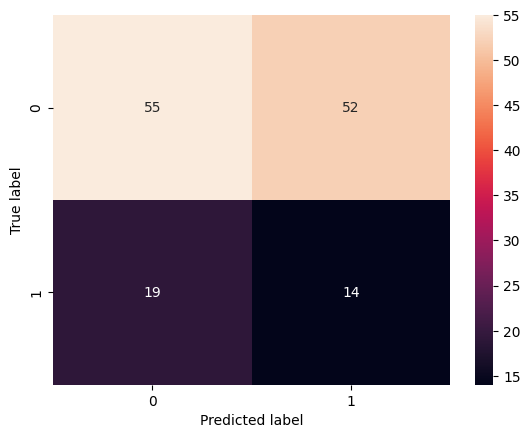

In [63]:
# model with random prediction
def random_prediction_model(X):
    random_out = keras.layers.Lambda(lambda x: tf.random.uniform([tf.shape(x)[0], 1], minval=0, maxval=1))(X)
    model = keras.Model(inputs=X, outputs=random_out)
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy', metrics.Precision(), metrics.Recall(), metrics.AUC()])
    return model

model_rand = random_prediction_model(X_input)

#evaluate the model
Y_pred_rand = model_rand.predict(X_test)
Y_pred_binary_rand = np.round(Y_pred_rand)
Y_true_rand = Y_test

print(classification_report(Y_true_rand, Y_pred_binary_rand))
print("Accuracy score:", accuracy_score(Y_true_rand, Y_pred_binary_rand))

# confusion matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(Y_true_rand, Y_pred_binary_rand)
sns.heatmap(cm, annot=True, fmt='d')
# label the acis
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.show()





In [21]:
from sklearn.metrics import classification_report, f1_score, accuracy_score, precision_score, recall_score, roc_auc_score

# evaluate the model
y_pred = model2.predict(X_test)
y_pred_binary = np.round(y_pred)
y_true = y_test

print(classification_report(y_true, y_pred_binary))



print("Accuracy score:", accuracy_score(y_true, y_pred_binary))
print("AUC score:", roc_auc_score(y_true, y_pred))
print("F1 score:", f1_score(y_true, y_pred_binary))
print("Precision score:", precision_score(y_true, y_pred_binary))
print("Recall score:", recall_score(y_true, y_pred_binary))

3/3 [==============================] - 0s 2ms/step
              precision    recall  f1-score   support

         0.0       0.93      0.98      0.96        57
         1.0       0.97      0.90      0.93        39

    accuracy                           0.95        96
   macro avg       0.95      0.94      0.95        96
weighted avg       0.95      0.95      0.95        96

Accuracy score: 0.9479166666666666
AUC score: 0.9914529914529915
F1 score: 0.9333333333333333
Precision score: 0.9722222222222222
Recall score: 0.8974358974358975
